In [8]:
# Importing necessary libraries
import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph,START,END
from langchain_anthropic import ChatAnthropic
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage,HumanMessage
from langchain_core.runnables import RunnableConfig
from typing import TypedDict,List,Literal, Dict, Any
from typing_extensions import Annotated, Optional
from pydantic import BaseModel,Field
from dataclasses import dataclass, fields
from langchain.chat_models import init_chat_model
from tavily import AsyncTavilyClient
from enum import Enum
from langgraph.types import interrupt,Command
from langgraph.constants import Send
import asyncio
import operator
import uuid
from langgraph.checkpoint.memory import MemorySaver
load_dotenv()

True

In [9]:
# Loading the environment variables and model
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")
llm = ChatGroq(model="gemma2-9b-it",temperature=0.3)
llm.invoke("Hi! I am Hrishikesh")

AIMessage(content="Hello Hrishikesh! 👋\n\nIt's nice to meet you. What can I do for you today? 😊  \n", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 17, 'total_tokens': 46, 'completion_time': 0.052727273, 'prompt_time': 0.001995986, 'queue_time': 0.23389021899999998, 'total_time': 0.054723259}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-2190fc6f-ac69-47b0-9aa5-fbf7ec5a4eb7-0', usage_metadata={'input_tokens': 17, 'output_tokens': 29, 'total_tokens': 46})

In [10]:
# Schema Models
class Section(BaseModel):
    name: str = Field(description="Name for this section of the report.",)
    description: str = Field(description="Brief overview of the main topics and concepts to be covered in this section.",)
    research: bool = Field(description="Whether to perform web research for this section of the report.")
    content: str = Field(description="The content of the section.")   
    
class Sections(BaseModel):
    sections: List[Section] = Field(description="Sections of the report.",)

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(description="List of search queries.",)

class Feedback(BaseModel):
    grade: Literal["pass","fail"] = Field(description="Evaluation result indicating whether the response meets requirements ('pass') or needs revision ('fail').")
    follow_up_queries: List[SearchQuery] = Field(description="List of follow-up search queries.",)

# States
class ReportStateInput(TypedDict):
    topic: str # Report topic
    
class ReportStateOutput(TypedDict):
    final_report: str # Final report    
    
# Overall State    
class ReportState(TypedDict):
    topic: str # Report topic    
    feedback_on_report_plan: str # Feedback on the report plan
    sections: list[Section] # List of report sections 
    completed_sections: Annotated[list, operator.add] # Send() API key
    report_sections_from_research: str # String of any completed sections from research to write final sections
    final_report: str # Final report
    
class SectionState(TypedDict):
    topic: str # Report topic
    section: Section # Report section  
    search_iterations: int # Number of search iterations done
    search_queries: list[SearchQuery] # List of search queries
    source_str: str # String of formatted source content from web search
    report_sections_from_research: str # String of any completed sections from research to write final sections
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API
    
class SectionOutputState(TypedDict):
    completed_sections: list[Section] # Final key we duplicate in outer state for Send() API

In [11]:
#prompts
report_planner_query_writer_instructions="""
You are performing research for a report. 

<Report topic>
{topic}
</Report topic>

<Report organization>
{report_organization}
</Report organization>

<Task>
Your goal is to generate {number_of_queries} web search queries that will help gather information for planning the report sections. 

The queries should:

1. Be related to the Report topic
2. Help satisfy the requirements specified in the report organization

Make the queries specific enough to find high-quality, relevant sources while covering the breadth needed for the report structure.
</Task>

<Format>
Call the Queries tool 
</Format>
"""

report_planner_instructions="""I want a plan for a report that is concise and focused.

<Report topic>
The topic of the report is:
{topic}
</Report topic>

<Report organization>
The report should follow this organization: 
{report_organization}
</Report organization>

<Context>
Here is context to use to plan the sections of the report: 
{context}
</Context>

<Task>
Generate a list of sections for the report. Your plan should be tight and focused with NO overlapping sections or unnecessary filler. 

For example, a good report structure might look like:
1/ intro
2/ overview of topic A
3/ overview of topic B
4/ comparison between A and B
5/ conclusion

Each section should have the fields:

- Name - Name for this section of the report.
- Description - Brief overview of the main topics covered in this section.
- Research - Whether to perform web research for this section of the report.
- Content - The content of the section, which you will leave blank for now.

Integration guidelines:
- Include examples and implementation details within main topic sections, not as separate sections
- Ensure each section has a distinct purpose with no content overlap
- Combine related concepts rather than separating them

Before submitting, review your structure to ensure it has no redundant sections and follows a logical flow.
</Task>

<Feedback>
Here is feedback on the report structure from review (if any):
{feedback}
</Feedback>

<Format>
Call the Sections tool 
</Format>
"""

query_writer_instructions="""You are an expert technical writer crafting targeted web search queries that will gather comprehensive information for writing a technical report section.

<Report topic>
{topic}
</Report topic>

<Section topic>
{section_topic}
</Section topic>

<Task>
Your goal is to generate {number_of_queries} search queries that will help gather comprehensive information above the section topic. 

The queries should:

1. Be related to the topic 
2. Examine different aspects of the topic

Make the queries specific enough to find high-quality, relevant sources.
</Task>

<Format>
Call the Queries tool 
</Format>
"""

section_writer_instructions = """Write one section of a research report.

<Task>
1. Review the report topic, section name, and section topic carefully.
2. If present, review any existing section content. 
3. Then, look at the provided Source material.
4. Decide the sources that you will use it to write a report section.
5. Write the report section and list your sources. 
</Task>

<Writing Guidelines>
- If existing section content is not populated, write from scratch
- If existing section content is populated, synthesize it with the source material
- Strict 150-200 word limit
- Use simple, clear language
- Use short paragraphs (2-3 sentences max)
- Use ## for section title (Markdown format)
</Writing Guidelines>

<Citation Rules>
- Assign each unique URL a single citation number in your text
- End with ### Sources that lists each source with corresponding numbers
- IMPORTANT: Number sources sequentially without gaps (1,2,3,4...) in the final list regardless of which sources you choose
- Example format:
  [1] Source Title: URL
  [2] Source Title: URL
</Citation Rules>

<Final Check>
1. Verify that EVERY claim is grounded in the provided Source material
2. Confirm each URL appears ONLY ONCE in the Source list
3. Verify that sources are numbered sequentially (1,2,3...) without any gaps
</Final Check>
"""

section_writer_inputs=""" 
<Report topic>
{topic}
</Report topic>

<Section name>
{section_name}
</Section name>

<Section topic>
{section_topic}
</Section topic>

<Existing section content (if populated)>
{section_content}
</Existing section content>

<Source material>
{context}
</Source material>
"""

section_grader_instructions = """Review a report section relative to the specified topic:

<Report topic>
{topic}
</Report topic>

<section topic>
{section_topic}
</section topic>

<section content>
{section}
</section content>

<task>
Evaluate whether the section content adequately addresses the section topic.

If the section content does not adequately address the section topic, generate {number_of_follow_up_queries} follow-up search queries to gather missing information.
</task>

<format>
Call the Feedback tool and output with the following schema:

grade: Literal["pass","fail"] = Field(
    description="Evaluation result indicating whether the response meets requirements ('pass') or needs revision ('fail')."
)
follow_up_queries: List[SearchQuery] = Field(
    description="List of follow-up search queries.",
)
</format>
"""


In [22]:
# utils
async def tavily_search_async(search_queries):
    print("---- INTO THE TAVILY SEARCH FUNCTION ----")
    tavily_async_client = AsyncTavilyClient()
    search_tasks = []
    for query in search_queries:
            search_tasks.append(
                tavily_async_client.search(
                    query,
                    max_results=2,
                    include_raw_content=True,
                    topic="general"
                )
            )

    # Execute all searches concurrently
    search_docs = await asyncio.gather(*search_tasks)
    print(f"search docs : {search_docs}")
    return search_docs

def deduplicate_and_format_sources(search_response, max_tokens_per_source=2000, include_raw_content=False):
    sources_list = []
    for response in search_response:
        sources_list.extend(response['results'])
    unique_sources = {source['url']: source for source in sources_list}
    formatted_text = "Content from sources:\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"{'='*50}\n"  # Clear section separator
        formatted_text += f"Source: {source['title']}\n"
        formatted_text += f"{'-'*50}\n"  # Subsection separator
        formatted_text += f"URL: {source['url']}\n===\n"
        formatted_text += f"Relevant content from source: {source['content']}\n===\n"
        if include_raw_content:
            # Using rough estimate of 4 characters per token
            char_limit = max_tokens_per_source * 4
            # Handle None raw_content
            raw_content = source.get('raw_content', '')
            if raw_content is None:
                raw_content = ''
                print(f"Warning: No raw_content found for source {source['url']}")
            if len(raw_content) > char_limit:
                raw_content = raw_content[:char_limit] + "... [truncated]"
            formatted_text += f"Full source content limited to {max_tokens_per_source} tokens: {raw_content}\n\n"
        formatted_text += f"{'='*80}\n\n" # End section separator
                
    return formatted_text.strip()

async def select_and_execute_search(query_list:list[str]) -> str:
    search_results = await tavily_search_async(query_list)
    return deduplicate_and_format_sources(search_results, max_tokens_per_source=4000, include_raw_content=False)

In [31]:
# Configuration
DEFAULT_REPORT_STRUCTURE = """Use this structure to create a report on the user-provided topic:

1. Introduction (no research needed)
   - Brief overview of the topic area

2. Main Body Sections:
   - Each section should focus on a sub-topic of the user-provided topic
   
3. Conclusion
   - Aim for 1 structural element (either a list of table) that distills the main body sections 
   - Provide a concise summary of the report
"""

class SearchAPI(Enum):
    PERPLEXITY = "perplexity"
    TAVILY = "tavily"
    EXA = "exa"
    ARXIV = "arxiv"
    PUBMED = "pubmed"
    LINKUP = "linkup"
    DUCKDUCKGO = "duckduckgo"
    GOOGLESEARCH = "googlesearch"

@dataclass(kw_only=True)
class Configuration:
    """The configurable fields for the chatbot."""
    report_structure: str = DEFAULT_REPORT_STRUCTURE # Defaults to the default report structure
    number_of_queries: int = 2 # Number of search queries to generate per iteration
    max_search_depth: int = 2 # Maximum number of reflection + search iterations
    planner_provider: str = "groq"  # Defaults to Anthropic as provider
    planner_model: str = "llama-3.3-70b-versatile" # Defaults to llama-3.3-70b-versatile
    writer_provider: str = "groq" # Defaults to groq as provider
    writer_model: str = "gemma2-9b-it" # Defaults to llama-3.3-70b-versatile
    search_api: SearchAPI = SearchAPI.TAVILY # Default to TAVILY
    search_api_config: Optional[Dict[str, Any]] = None 

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }
        return cls(**{k: v for k, v in values.items() if v})


##### generate_report_plan() function

In [35]:
async def generate_report_plan(state:ReportState, config:RunnableConfig):
    """Generate the initial report plan with sections.
    
    This node:
    1. Gets configuration for the report structure and search parameters
    2. Generates search queries to gather context for planning
    3. Performs web searches using those queries
    4. Uses an LLM to generate a structured plan with sections
    
    Args:
        state: Current graph state containing the report topic
        config: Configuration for models, search APIs, etc.
        
    Returns:
        Dict containing the generated sections
    """
    topic = state["topic"]
    feedback = state.get("feedback_on_report_plan",None)
    
    configurable = Configuration.from_runnable_config(config)
    report_structure = configurable.report_structure
    number_of_queries = configurable.number_of_queries
    search_api = configurable.search_api
    search_api_config = configurable.search_api_config or {}  # Get the config dict, default to empty
    planner_model_name = configurable.planner_model
    planner_provider = configurable.planner_provider
    writer_provider = configurable.writer_provider
    writer_model_name = configurable.writer_model
    writer_model = init_chat_model(model=writer_model_name, model_provider=writer_provider) 
    structured_llm = writer_model.with_structured_output(Queries)
    
    system_instructions_query = report_planner_query_writer_instructions.format(topic=topic, report_organization=report_structure, number_of_queries=number_of_queries)
    # print("System_instructions_query : ",system_instructions_query)
    
    # print("structured_llm : ",structured_llm)
    results = structured_llm.invoke([SystemMessage(content=system_instructions_query)]+[HumanMessage(content="Generate search queries that will help with planning the sections of the report.")])
    # print("Result of the search query : ",results)
    
    # web search
    query_list = [query.search_query for query in results.queries]
    # print("Query List : ",query_list)
    
    # search the web for each query parallely
    source_str = await select_and_execute_search(query_list)
    # print(source_str)
    system_instructions_sections = report_planner_instructions.format(topic=topic, report_organization=report_structure, context=source_str, feedback=feedback)
    planner_message = """Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. 
                        Each section must have: name, description, plan, research, and content fields."""
    
    planner_llm = init_chat_model(model=planner_model_name,
                                      model_provider=planner_provider, 
                                      max_tokens=15000,
                                      max_retries=1,
                                    # thinking={"type": "enabled", "budget_tokens": 16_000}
    )
    
    structured_llm = planner_llm.with_structured_output(Sections)
    report_sections = structured_llm.invoke([SystemMessage(content=system_instructions_sections),
                                             HumanMessage(content=planner_message)])

    # Get sections
    sections = report_sections.sections

    return {"sections": sections}

##### build_section_with_web_research (SubGraph)

In [36]:
def generate_queries(state:SectionState,config:RunnableConfig):
    """Generate search queries for researching a specific section.
    
    This node uses an LLM to generate targeted search queries based on the 
    section topic and description.
    
    Args:
        state: Current state containing section details
        config: Configuration including number of queries to generate
        
    Returns:
        Dict containing the generated search queries
    """
    print("---- INTO THE GENERATE QUERIES NODE OF SUBGRAPH ----")
    topic = state["topic"]
    section = state["section"]
    
    configurable = Configuration.from_runnable_config(config=config)
    number_of_queries = configurable.number_of_queries
    writer_provider = configurable.writer_provider
    writer_model_name = configurable.writer_model
    writer_model = init_chat_model(model=writer_model_name, model_provider=writer_provider,max_retries=1,max_tokens=1000) 
    structured_llm = writer_model.with_structured_output(Queries)
    system_instructions = query_writer_instructions.format(topic=topic, 
                                                           section_topic=section.description, 
                                                           number_of_queries=number_of_queries)

    queries = structured_llm.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate search queries on provideded topic")])
    print(f"Queries generated for section {state['section']} : {queries.queries}")
    return {"search_queries":queries.queries}

async def search_web(state:SectionState,config:RunnableConfig):
    """Execute web searches for the section queries.
    
    This node:
    1. Takes the generated queries
    2. Executes searches using configured search API
    3. Formats results into usable context
    
    Args:
        state: Current state with search queries
        config: Search API configuration
        
    Returns:
        Dict with search results and updated iteration count
    """
    print("---- INTO THE SEARCH WEB NODE OF SUBGRAPH ----")
    search_queries = state["search_queries"]
    
    configurable = Configuration.from_runnable_config(config=config)
    search_api = configurable.search_api
    query_list = [query.search_query for query in search_queries]
    source_str = await select_and_execute_search(query_list)
    print(f"Source str for section {state['section']} : {source_str}")
    return {"source_str":source_str,"search_iterations":state["search_iterations"]+1}

def write_section(state:SectionState,config:RunnableConfig):
    """Write a section of the report and evaluate if more research is needed.
    
    This node:
    1. Writes section content using search results
    2. Evaluates the quality of the section
    3. Either:
       - Completes the section if quality passes
       - Triggers more research if quality fails
    
    Args:
        state: Current state with search results and section info
        config: Configuration for writing and evaluation
        
    Returns:
        Command to either complete section or do more research
    """
    print("---- INTO THE WRITE SECTION NODE OF SUBGRAPH ----")
    topic = state["topic"]
    section = state["section"]
    source_str = state["source_str"]
    
    configurable = Configuration.from_runnable_config()
    section_writer_inputs_formatted = section_writer_inputs.format(topic=topic, 
                                                             section_name=section.name, 
                                                             section_topic=section.description, 
                                                             context=source_str, 
                                                             section_content=section.content)
    writer_provider = configurable.writer_provider
    writer_model_name = configurable.writer_model
    writer_model = init_chat_model(model=writer_model_name, model_provider=writer_provider) 

    section_content = writer_model.invoke([SystemMessage(content=section_writer_instructions),
                                           HumanMessage(content=section_writer_inputs_formatted)])
    print(f"content written for the {state['section']} : {section_content.content}")
    section.content = section_content.content
    
    section_grader_message = ("Grade the report and consider follow-up questions for missing information. "
                              "If the grade is 'pass', return empty strings for all follow-up queries. "
                              "If the grade is 'fail', provide specific search queries to gather missing information. ")
    system_instructions = section_grader_instructions.format(topic=topic, 
                                                                    section_topic=section.description,
                                                                    section=section.content, 
                                                                    number_of_follow_up_queries=configurable.number_of_queries)
    planner_model = configurable.planner_model
    planner_provider = configurable.planner_provider
    reflection_model = init_chat_model(model=planner_model,model_provider=planner_provider,max_tokens=1000,max_retries=1).with_structured_output(Feedback)
    feedback = reflection_model.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content=section_grader_message)])
    
    if feedback.grade == "pass" or state["search_iterations"] >= configurable.max_search_depth:
        return Command(goto=END,update={"completed_sections":[section]})
    else:
        return Command(goto="search_web",update={"search_queries":feedback.follow_up_queries,"section":section})
    

section_builder = StateGraph(SectionState,output=SectionOutputState)
section_builder.add_node("generate_queries",generate_queries)
section_builder.add_node("search_web",search_web)
section_builder.add_node("write_section",write_section)

section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web","write_section")

##### human_feedback() function

In [37]:
def human_feedback(state: ReportState,config:RunnableConfig) -> Command[Literal["generate_report_plan","build_section_with_web_research"]]:
    """Get human feedback on the report plan and route to next steps.
    
    This node:
    1. Formats the current report plan for human review
    2. Gets feedback via an interrupt
    3. Routes to either:
       - Section writing if plan is approved
       - Plan regeneration if feedback is provided
    
    Args:
        state: Current graph state with sections to review
        config: Configuration for the workflow
        
    Returns:
        Command to either regenerate plan or start section writing
    """

    # Get sections
    topic = state["topic"]
    sections = state['sections']
    sections_str = "\n\n".join(
        f"Section: {section.name}\n"
        f"Description: {section.description}\n"
        f"Research needed: {'Yes' if section.research else 'No'}\n"
        for section in sections
    )

    # Get feedback on the report plan from interrupt
    interrupt_message = f"""Please provide feedback on the following report plan. 
                        \n\n{sections_str}\n
                        \nDoes the report plan meet your needs?\nPass 'true' to approve the report plan.\nOr, provide feedback to regenerate the report plan:"""
    
    feedback = interrupt(value=interrupt_message)
    
    # If the user approves the report plan, kick off section writing
    if isinstance(feedback, bool) and feedback is True:
        # Treat this as approve and kick off section writing
        print("into the feedback boolean")
        return Command(goto=[
            Send("build_section_with_web_research", {"topic": topic, "section": s, "search_iterations": 0}) for s in sections if s.research])
    
    # If the user provides feedback, regenerate the report plan
    elif isinstance(feedback, str):
        # Treat this as feedback
        print("into the feedback string")
        return Command(goto="generate_report_plan", 
                       update={"feedback_on_report_plan": feedback})
    else:
        raise TypeError(f"Interrupt value of type {type(feedback)} is not supported.")

##### Parent Graph Creation

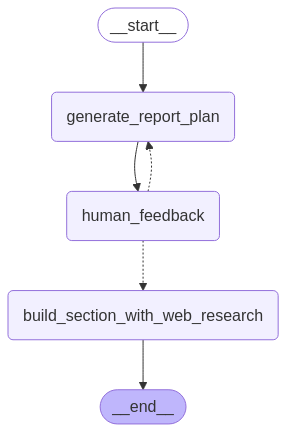

In [38]:

builder = StateGraph(ReportState, input=ReportStateInput, output=ReportStateOutput, config_schema=Configuration)
builder.add_node("generate_report_plan",generate_report_plan)
builder.add_node("human_feedback",human_feedback)
builder.add_node("build_section_with_web_research",section_builder.compile())

builder.add_edge(START,"generate_report_plan")
builder.add_edge("generate_report_plan","human_feedback")
builder.add_edge("build_section_with_web_research",END)
graph = builder.compile(MemorySaver())
graph

In [39]:
config = {"configurable": {"thread_id": str(uuid.uuid4()),
                           "search_api": "tavily",
                           "max_search_depth": 1,
                           }}

In [40]:
topic = "Overview of the AI inference market with focus on Langgraph, CrewAI and Autogen"
async for event in graph.astream({"topic":topic,}, stream_mode="updates",config=config):
    if '__interrupt__' in event:
        print(event["__interrupt__"][0].value)

---- INTO THE TAVILY SEARCH FUNCTION ----
search docs : [{'query': 'Langgraph, CrewAI, and Autogen AI inference market share and growth projections', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': 'Mastering Agents: LangGraph Vs Autogen Vs Crew AI', 'url': 'https://www.galileo.ai/blog/mastering-agents-langgraph-vs-autogen-vs-crew', 'content': 'CriteriaLangGraphAutogenCrew AIFinal VerdictEase of Usage❌✅✅Autogen and Crew AI are more intuitive due to their conversational approach and simplicity.Multi-Agent Support✅✅✅Crew AI excels with its structured role-based design and efficient interaction management among multiple agents.Tool Coverage✅✅✅LangGraph and Crew AI have a slight edge due to their extensive integration with LangChain.Memory Support✅✅✅LangGraph and Crew AI are advanced in memory support features, ensuring contextual awareness and learning over time.Structured Output✅✅✅LangGraph and Crew AI have strong support for structured outputs that are v

In [41]:
# feedback = input()
async for event in graph.astream(input=Command(resume=True), config=config, stream_mode="updates"):
    print(event)

into the feedback boolean
{'human_feedback': None}
---- INTO THE GENERATE QUERIES NODE OF SUBGRAPH ----
---- INTO THE GENERATE QUERIES NODE OF SUBGRAPH ----
---- INTO THE GENERATE QUERIES NODE OF SUBGRAPH ----
---- INTO THE GENERATE QUERIES NODE OF SUBGRAPH ----
Queries generated for section name='Comparison of LangGraph, CrewAI, and Autogen' description='Comparison of the features and functionalities of LangGraph, CrewAI, and Autogen' research=True content='' : [SearchQuery(search_query='Langgraph, CrewAI, and Autogen: feature comparison chart'), SearchQuery(search_query='Langgraph vs CrewAI vs Autogen: technical capabilities and use cases')]
---- INTO THE SEARCH WEB NODE OF SUBGRAPH ----
---- INTO THE TAVILY SEARCH FUNCTION ----
Queries generated for section name='CrewAI Overview' description='Overview of CrewAI features and functionalities' research=True content='' : [SearchQuery(search_query='CrewAI features and functionalities detailed overview'), SearchQuery(search_query='CrewAI 

In [45]:
graph.get_state(config=config,subgraphs=True).values

{'topic': 'Overview of the AI inference market with focus on Langgraph, CrewAI and Autogen',
 'sections': [Section(name='Introduction', description='Overview of the AI inference market', research=False, content=''),
  Section(name='LangGraph Overview', description='Overview of LangGraph features and functionalities', research=True, content='## LangGraph Overview\n\nLangGraph is a framework designed to build and execute graph-based workflows powered by large language models (LLMs).  It allows developers to model AI applications as directed graphs, where each node represents a processing step and edges define data flow.  This visual and modular approach simplifies the development of complex AI pipelines, such as chatbots, data retrieval systems, or decision-making systems.\n\nLangGraph distinguishes itself by enabling cycles in its graphs, allowing for more complex, agent-like behaviors. This means LLMs can be called in loops, enabling them to dynamically adapt and make decisions based o